# Validating Gibbs sampling

**Last updated: September 9,2021**

In this code I will check Gibbs sampling method for two dimensional probability distributions. These two dimensional distributions correspond to prior and posterior distributions in POISE-VAE.<br>
The prior distribution is given by,
<span class="math display">
    \begin{aligned}
    p(z,z')\sim \mathrm{exp}\left(-(z^2+z'^2)+g_{11}zz'+g_{22}z^2z'^2\right)
    \end{aligned}
</span>
The posterior distribution is given by,
<span class="math display">
    \begin{aligned}
    q(z,z'|x,x')\sim \mathrm{exp}\left(-(z^2+z'^2)+g_{11}zz'+g_{22}z^2z'^2\lambda_1(x)z+\lambda_2(x)z^2+\lambda'_1(x')z'+\lambda'_2(x'){z'}^2\right)
    \end{aligned}
</span>
We have the following constraints,
<span class="math display">
    \begin{aligned}
    g_{22}&<0\\
    \lambda_2(x)&<0\\
    \lambda'_2(x')&<0\\
    \alpha&<0
    \end{aligned}
</span>

In [1]:
import torch
import import_ipynb
import gibbs_sampler_new
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from sklearn.neighbors import KernelDensity
import random
import plot_utils as pu

random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gibbs = gibbs_sampler_new.gibbs_sampler() 

importing Jupyter notebook from gibbs_sampler_new.ipynb


I am assuming the following:
<span class="math display">
    \begin{aligned}
    g_{11}&=\mathcal{N}(1,1)\\
    g_{22}&<0
    \end{aligned}
</span>

In [2]:
g11    = torch.randn(1,1).to(device)
g22    = -torch.exp(1+torch.randn(1,1)).to(device)

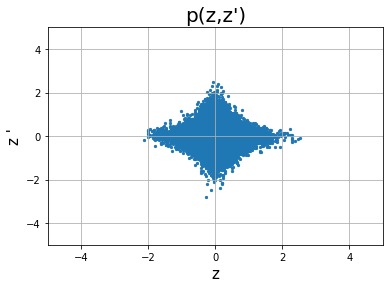

In [3]:
x_val_prior =[]
y_val_prior =[]
z_prior,zp_prior  = gibbs.initialize_prior_sample(g11,g22)
#p(z,z') Gibbs sampling
for i in np.arange(15000):
    z1_prior,z2_prior = gibbs.prior_sample(z_prior,zp_prior,g11,g22)
    z1_prior=z1_prior.cpu().detach().numpy()
    z2_prior=z2_prior.cpu().detach().numpy()
    z1_prior=z1_prior.squeeze()
    z2_prior=z2_prior.squeeze()
    x_val_prior=np.hstack((x_val_prior,z1_prior))
    y_val_prior=np.hstack((y_val_prior,z2_prior))
plt.scatter(x_val_prior,y_val_prior,s=5)
plt.xlabel('z',fontsize=15)
plt.ylabel('z \'',fontsize=15)
plt.title('p(z,z\')',fontsize=20)
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.grid()
plt.show()

I calculate the partition function of the prior by integrating the following function from -infinity to infinity
<span class="math display">
    \begin{aligned}
    \lambda(y,x)= \mathrm{exp}\left(-x^2-y^2+g_{11}xy+g_{22}x^2y^2+g_{12}(x^2y+{y}^2x)\right)
    \end{aligned}
</span>

In [4]:
## Numerica integration of prior
g_11=float(g11.cpu().detach().numpy())
g_22=float(g22.cpu().detach().numpy())
f = lambda y, x: np.exp(-x**2 - y**2+g_11*x*y+g_22*(x**2)*(y**2))
Z_prior, err=integrate.dblquad(f, -np.inf, np.inf, lambda x: -np.inf, lambda x: np.inf)

I evaluate various points of the prior distribution using the formula,
<span class="math display">
    \begin{aligned}
    \mathrm{zlist}(x,y)= \frac{1}{\mathcal{Z}}\mathrm{exp}\left(-x^2-y^2+g_{11}xy+g_{22}x^2y^2\right)
    \end{aligned}
</span>

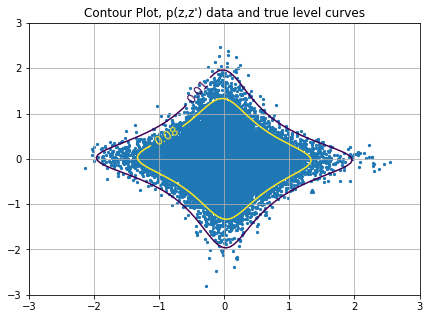

In [5]:
xlist_prior = np.linspace(-3.0, 3.0, 100)
ylist_prior = np.linspace(-3.0, 3.0, 100)
zlist_prior = np.ndarray((100,100))
levels=[0.01,0.08]
for x in range(0, len(xlist_prior)):
    for y in range(0, len(ylist_prior)):
        zlist_prior[x][y] = 1/Z_prior*np.exp(-xlist_prior[x]**2 - ylist_prior[y]**2+g_11*xlist_prior[x]*ylist_prior[y]+g_22*(xlist_prior[x]**2)*(ylist_prior[y]**2))
plt.figure(figsize=(7, 5))
plt.title('Contour Plot, p(z,z\') data and true level curves')
contours = plt.contour(xlist_prior, ylist_prior, zlist_prior,levels)
plt.scatter(x_val_prior,y_val_prior,s=5)
plt.clabel(contours,inline=1,  fontsize=12)
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.grid()
plt.show()

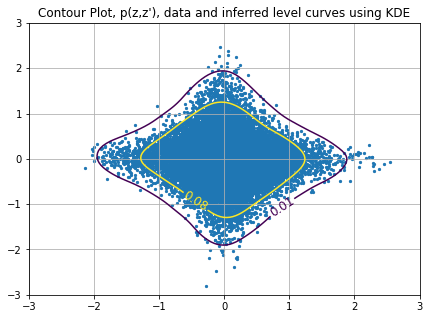

In [6]:
def kde2D(x, y, bandwidth, xbins=100j, ybins=100j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""
    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)
    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)
levels=[0.01,0.08]
xx_prior, yy_prior, zz_prior = kde2D(x_val_prior, y_val_prior, 0.2)
plt.figure(figsize=(7, 5))
plt.title('Contour Plot, p(z,z\'), data and inferred level curves using KDE')
contours=plt.contour(xx_prior, yy_prior, zz_prior,levels)
plt.clabel(contours,inline=1,  fontsize=12)
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.scatter(x_val_prior, y_val_prior, s=5)
plt.grid()
plt.show()

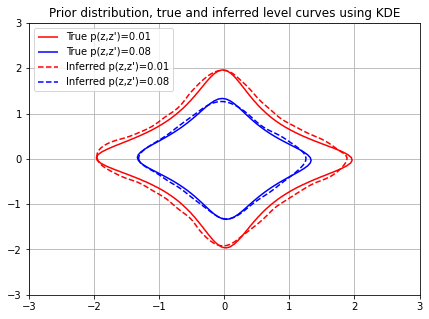

In [7]:
levels=[0.01,0.08]
xx_prior, yy_prior, zz_prior = kde2D(x_val_prior, y_val_prior, 0.15)
plt.figure(figsize=(7, 5))
plt.title('Prior distribution, true and inferred level curves using KDE')
contours_true = plt.contour(xlist_prior, ylist_prior, zlist_prior,levels,colors=['red','blue'])
contours_kde  = plt.contour(xx_prior, yy_prior, zz_prior,levels,linestyles='dashed',colors=['red','blue'])
#plt.clabel(contours_true,inline=1,  fontsize=12)
#plt.clabel(contours_kde,inline=1,  fontsize=12)
plt.xlim([-3, 3])
plt.ylim([-3, 3])
labels_true = ['True p(z,z\')=0.01', 'True p(z,z\')=0.08']
labels_kde = ['Inferred p(z,z\')=0.01', 'Inferred p(z,z\')=0.08']
for i in range(len(labels_true)):
    contours_true.collections[i].set_label(labels_true[i])
for i in range(len(labels_kde)):
    contours_kde.collections[i].set_label(labels_kde[i])
plt.grid()
plt.legend(loc='upper left')
plt.show()

The posterior distribution is given by,
<span class="math display">
    \begin{aligned}
    q(z,z'|x,x')\sim \mathrm{exp}\left(-(z^2+z'^2)+g_{11}zz'+g_{22}z^2z'^2+\lambda_1(x)z+\lambda_2(x)z^2+\lambda'_1(x')z'+\lambda'_2(x'){z'}^2\right)
    \end{aligned}
</span>
I am assuming the following:
<span class="math display">
    \begin{aligned}
    g_{11}&=\mathcal{N}(0,1)\\
    g_{22}&<0\\
    \lambda_2(x)&<0 (-1.0)\\
    \lambda'_2(x')&<0 (-1.0)
    \end{aligned}
</span>

In [8]:
#lambda1  =  torch.randn(1,1).to(device)
lambda1  = torch.tensor(1).to(device)
lambdap1 = torch.tensor(1).to(device)

#lambdap1 =  torch.randn(1,1).to(device)
#lambda2  = -torch.exp(torch.randn(1,1)).to(device)
lambda2  = torch.tensor(-1).to(device)
#lambdap2 = -torch.exp(torch.randn(1,1)).to(device)
lambdap2  = torch.tensor(-1).to(device)


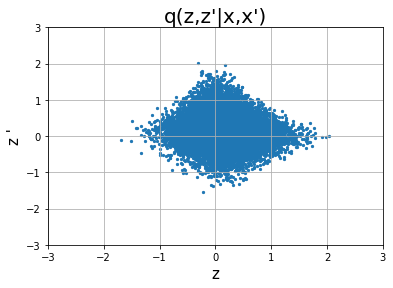

In [9]:
#q(z,z'|x,x')
x_val_posterior =[]
y_val_posterior =[]
z_posterior,zp_posterior  = gibbs.initialize_posterior_sample(g11,g22,lambda1,lambda2,lambdap1,lambdap2)

for i in np.arange(15000):
    z1_posterior,z2_posterior = gibbs.posterior_sample(z_posterior,zp_posterior,g11,g22,lambda1,lambda2,lambdap1,lambdap2)
    z1_posterior=z1_posterior.cpu().detach().numpy()
    z2_posterior=z2_posterior.cpu().detach().numpy()
    z1_posterior=z1_posterior.squeeze()
    z2_posterior=z2_posterior.squeeze()
    x_val_posterior=np.hstack((x_val_posterior,z1_posterior))
    y_val_posterior=np.hstack((y_val_posterior,z2_posterior))
plt.scatter(x_val_posterior,y_val_posterior,s=5)
plt.xlabel('z',fontsize=15)
plt.ylabel('z \'',fontsize=15)
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.title('q(z,z\'|x,x\')',fontsize=20)
plt.grid()
plt.show()


I calculate the partition function of the posterior by integrating the following function from -infinity to infinity
<span class="math display">
    \begin{aligned}
    \lambda(y,x)= \mathrm{exp}\left(-x^2-y^2+g_{11}xy+g_{22}x^2y^2+\lambda_1x+\lambda_2x^2+\lambda'_1y+\lambda'_2y^2\right)
    \end{aligned}
</span>

In [10]:
## Numerica integration of posterior
g_11      =float(g11.cpu().detach().numpy())
g_22      =float(g22.cpu().detach().numpy())
lambda_1 =float(lambda1.cpu().detach().numpy())
lambda_2 =float(lambda2.cpu().detach().numpy())
lambdap_1=float(lambdap1.cpu().detach().numpy())
lambdap_2=float(lambdap2.cpu().detach().numpy())

f = lambda y, x: np.exp(-x**2 - y**2+g_11*x*y+g_22*(x**2)*(y**2)+lambda_1*x+lambda_2*(x**2)+lambdap_1*y+lambdap_2*(y**2))
Z_post, err=integrate.dblquad(f, -np.inf, np.inf, lambda x: -np.inf, lambda x: np.inf)

I evaluate various points of the posterior distribution using the formula,
<span class="math display">
    \begin{aligned}
    \mathrm{zlist}(x,y)= \frac{1}{\mathcal{Z}}\mathrm{exp}\left(-x^2-y^2+g_{11}xy+g_{22}x^2y^2+\lambda_1x+\lambda_2x^2+\lambda'_1y+\lambda'_2y^2\right)
    \end{aligned}
</span>

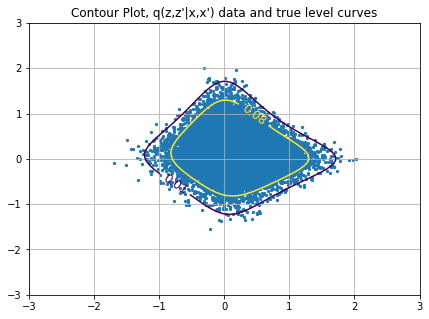

In [11]:
xlist_posterior = np.linspace(-3.0, 3.0, 100)
ylist_posterior = np.linspace(-3.0, 3.0, 100)
zlist_posterior = np.ndarray((100,100))
for x in range(0, len(xlist_posterior)):
    for y in range(0, len(ylist_posterior)):
        zlist_posterior[x][y] = 1/Z_post*np.exp(-xlist_posterior[x]**2 - ylist_posterior[y]**2+g_11*xlist_posterior[x]*ylist_posterior[y]+g_22*(xlist_posterior[x]**2)*(ylist_posterior[y]**2)+lambda_1*xlist_posterior[x]+lambda_2*(xlist_posterior[x]**2)+lambdap_1*ylist_posterior[y]+lambdap_2*(ylist_posterior[y]**2))
levels=[0.01,0.08]
plt.figure(figsize=(7, 5))
plt.title('Contour Plot, q(z,z\'|x,x\') data and true level curves')
contours = plt.contour(xlist_posterior, ylist_posterior, zlist_posterior,levels)
plt.scatter(x_val_posterior,y_val_posterior,s=5)
plt.clabel(contours,inline=1,  fontsize=12)
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.grid()
plt.show()

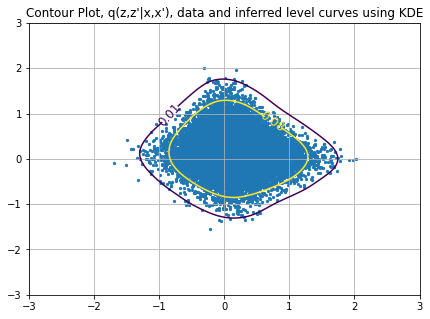

In [12]:
xx_posterior, yy_posterior, zz_posterior = kde2D(x_val_posterior, y_val_posterior, 0.2)
plt.figure(figsize=(7, 5))
plt.title('Contour Plot, q(z,z\'|x,x\'), data and inferred level curves using KDE')
contours=plt.contour(xx_posterior, yy_posterior, zz_posterior,levels)
plt.clabel(contours,inline=1,  fontsize=12)
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.scatter(x_val_posterior, y_val_posterior, s=5)
plt.grid()
plt.show()

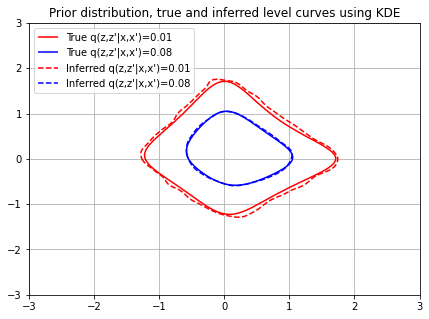

In [13]:
levels=[0.01,0.2]
xx_posterior, yy_posterior, zz_posterior = kde2D(x_val_posterior, y_val_posterior, 0.11)
plt.figure(figsize=(7, 5))
plt.title('Prior distribution, true and inferred level curves using KDE')
contours_true = plt.contour(xlist_posterior, ylist_posterior, zlist_posterior,levels,colors=['red','blue'])
contours_kde  = plt.contour(xx_posterior, yy_posterior, zz_posterior,levels,linestyles='dashed',colors=['red','blue'])
#plt.clabel(contours_true,inline=1,  fontsize=12)
#plt.clabel(contours_kde,inline=1,  fontsize=12)
plt.xlim([-3, 3])
plt.ylim([-3, 3])
labels_true = ['True q(z,z\'|x,x\')=0.01', 'True q(z,z\'|x,x\')=0.08']
labels_kde = ['Inferred q(z,z\'|x,x\')=0.01', 'Inferred q(z,z\'|x,x\')=0.08']
for i in range(len(labels_true)):
    contours_true.collections[i].set_label(labels_true[i])
for i in range(len(labels_kde)):
    contours_kde.collections[i].set_label(labels_kde[i])
plt.grid()
plt.legend(loc='upper left')
plt.show()

In [21]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['text.usetex'] = False

In [22]:
#pu.figure_setup()
#fig_size = pu.get_fig_size(17.8, 6.0)

fig, ax = plt.subplots(1, 2)
ax[0].set_aspect('equal', adjustable='box')
ax[1].set_aspect('equal', adjustable='box')

# ax[0].annotate("A", xy=(0.01,0.62), xycoords='figure fraction', fontsize=12)
# ax[1].annotate("B", xy=(0.49,0.62), xycoords='figure fraction', fontsize=12)
plt.subplots_adjust(bottom=0.3, left=0.05, right=0.95, wspace=0.20)
# Panel a
levels=[0.01,0.2]
xx_prior, yy_prior, zz_prior = kde2D(x_val_prior, y_val_prior, 0.15)
contours_true = ax[0].contour(xlist_prior, ylist_prior, zlist_prior,levels,colors=['red'])
contours_kde  = ax[0].contour(xx_prior, yy_prior, zz_prior,levels,linestyles='dashed',colors=['blue'])

ax[0].set_xlim([-3, 3])
ax[0].set_ylim([-3, 3])
labels_true = ['True']
labels_kde = ['Inferred']
for i in range(len(labels_true)):
    contours_true.collections[i].set_label(labels_true[i])
for i in range(len(labels_kde)):
    contours_kde.collections[i].set_label(labels_kde[i])
ax[0].set_title('Prior')
ax[0].set_xlabel('$z$',fontsize=12)
ax[0].set_ylabel('$z$ ',fontsize=12)
ax[0].legend(loc='upper left', prop={'size': 8})
ax[0].axes.xaxis.set_ticks([])
ax[0].axes.yaxis.set_ticks([])

# Panel b
levels=[0.01,0.2]
xx_posterior, yy_posterior, zz_posterior = kde2D(x_val_posterior, y_val_posterior, 0.13)
contours_true = plt.contour(xlist_posterior, ylist_posterior, zlist_posterior,levels,colors=['red'])
contours_kde  = plt.contour(xx_posterior, yy_posterior, zz_posterior,levels,linestyles='dashed',colors=['blue'])
ax[1].set_xlim([-3, 3])
ax[1].set_ylim([-3, 3])
ax[1].axes.xaxis.set_ticks([])
ax[1].axes.yaxis.set_ticks([])

labels_true = ['True']
labels_kde = ['Inferred']
for i in range(len(labels_true)):
    contours_true.collections[i].set_label(labels_true[i])
for i in range(len(labels_kde)):
    contours_kde.collections[i].set_label(labels_kde[i])
ax[1].set_title('Posterior')
ax[1].set_xlabel(r'$z$',fontsize=12)
ax[1].set_ylabel(r'$z\'$',fontsize=12)

ax[1].legend(loc='upper left', prop={'size': 8})
plt.savefig("../POISE_VAE_2D_2D/fig_1.pdf", dpi=300, bbox_inches='tight')


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


ValueError: 
z\'
   ^
Expected {accentprefixed | accent | symbol | c_over_c | function | group | frac | dfrac | binom | genfrac | overset | underset | sqrt | overline | operatorname}, found end of text  (at char 3), (line:1, col:4)

ValueError: 
z\'
   ^
Expected {accentprefixed | accent | symbol | c_over_c | function | group | frac | dfrac | binom | genfrac | overset | underset | sqrt | overline | operatorname}, found end of text  (at char 3), (line:1, col:4)

<Figure size 432x288 with 2 Axes>

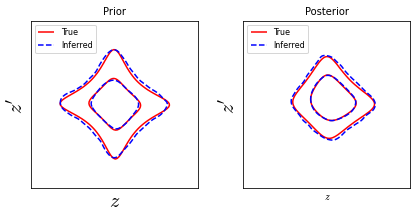

In [17]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
#plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['text.usetex'] = False
fig, ax = plt.subplots(1, 2)
ax[0].set_aspect('equal', adjustable='box')
ax[1].set_aspect('equal', adjustable='box')

# ax[0].annotate("A", xy=(0.01,0.62), xycoords='figure fraction', fontsize=12)
# ax[1].annotate("B", xy=(0.49,0.62), xycoords='figure fraction', fontsize=12)
plt.subplots_adjust(bottom=0.3, left=0.05, right=0.95, wspace=0.20)
# Panel a
levels=[0.01,0.2]
xx_prior, yy_prior, zz_prior = kde2D(x_val_prior, y_val_prior, 0.15)
contours_true = ax[0].contour(xlist_prior, ylist_prior, zlist_prior,levels,colors=['red'])
contours_kde  = ax[0].contour(xx_prior, yy_prior, zz_prior,levels,linestyles='dashed',colors=['blue'])

ax[0].set_xlim([-3, 3])
ax[0].set_ylim([-3, 3])
labels_true = ['True']
labels_kde = ['Inferred']
for i in range(len(labels_true)):
    contours_true.collections[i].set_label(labels_true[i])
for i in range(len(labels_kde)):
    contours_kde.collections[i].set_label(labels_kde[i])
ax[0].set_title('Prior',fontsize=10)
ax[0].set_xlabel('$z$')
ax[0].set_ylabel('$z\'$ ')
ax[0].legend(loc='upper left', prop={'size': 8})
ax[0].axes.xaxis.set_ticks([])
ax[0].axes.yaxis.set_ticks([])

# Panel b
levels=[0.01,0.2]
xx_posterior, yy_posterior, zz_posterior = kde2D(x_val_posterior, y_val_posterior, 0.13)
contours_true = plt.contour(xlist_posterior, ylist_posterior, zlist_posterior,levels,colors=['red'])
contours_kde  = plt.contour(xx_posterior, yy_posterior, zz_posterior,levels,linestyles='dashed',colors=['blue'])
ax[1].set_xlim([-3, 3])
ax[1].set_ylim([-3, 3])
ax[1].axes.xaxis.set_ticks([])
ax[1].axes.yaxis.set_ticks([])
ax[1].set_title('Posterior',fontsize=10)
ax[1].set_xlabel('$z$',fontsize=10)
ax[1].set_ylabel('$z\'$ ')
labels_true = ['True']
labels_kde = ['Inferred']
for i in range(len(labels_true)):
    contours_true.collections[i].set_label(labels_true[i])
for i in range(len(labels_kde)):
    contours_kde.collections[i].set_label(labels_kde[i])

ax[1].legend(loc='upper left', prop={'size': 8})
plt.savefig("../POISE_VAE_2D_2D/fig_1.pdf", dpi=300, bbox_inches='tight')


<Figure size 432x288 with 0 Axes>